## Calculate IoU - Average Precision - Precision Curve

In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from lxml import etree
import re
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

In [21]:
!ls -1 ./boundingbox/*.csv |grep "geo"

./boundingbox/correct_vgg16-dataset.v24.geo.slidingwindow.csv
./boundingbox/correct_vgg16-geo-dataset.1.geo.slidingwindow.csv
./boundingbox/correct_vgg16-geo-dataset.1.test.slidingwindow.csv
./boundingbox/correct_vgg16-geo-dataset.test.slidingwindow.csv
./boundingbox/correct_vgg16-sw-fc2k.3-dataset.v6.1arch.json.geo.slidingwindow.csv
./boundingbox/vgg16CAM-dataset-normal.geo.slidingwindow.csv
./boundingbox/vgg16-dataset10.geo.slidingwindow.csv
./boundingbox/vgg16-dataset11.geo.slidingwindow.csv
./boundingbox/vgg16-dataset7.geo.slidingwindow.csv
./boundingbox/vgg16-dataset8.geo.slidingwindow.csv
./boundingbox/vgg16-dataset9.geo.slidingwindow.csv
./boundingbox/vgg16-dataset-filtered-test.geo.slidingwindow.csv
./boundingbox/vgg16-dataset.fov-filtered-.geo.slidingwindow.csv
./boundingbox/vgg16-dataset-normal.geo.slidingwindow.csv
./boundingbox/vgg16-dataset.v6.1-filtered-.geo.slidingwindow.csv
./boundingbox/vgg16-dataset.v6.2-filtered-.geo.slidingwindow.csv
./boundingbox/vgg16-dataset.v6-f

### Change Prediction results to csv

In [22]:
prediction_test="correct_vgg16-dataset.v24.geo.slidingwindow.csv"

### Change Ground-truth to GEO, TEST or TRAIN

In [29]:
test="geo"
prediction_dir="./boundingbox/"
pd_file=join(prediction_dir,prediction_test)
    
if test=="train":
    mypath="/media/winpart/drone/filtertag/"
    label_dir="/media/winpart/drone/label"
    
elif test=="test":
    mypath="/media/winpart/drone/filtertest/"
    label_dir="/media/winpart/drone/upairtest/label"
    
elif test=="geo":
    mypath="/media/winpart/drone/filtergeo/"
    label_dir="/media/winpart/drone/upairtest_geo/label"

### Prediction Results

pred_df contains all the Predicted Plastic

In [30]:
pred_df=pd.read_csv(pd_file,header=None)
pred_df.columns = ['dataset','filename','x','y','x1','y1','confidence'] ## column names
pred_df['filename'] = [word.split(".")[0] for word in pred_df['filename']] ## strip .jpg

pred_df['filename'] = [word[6:] for word in pred_df['filename']] ## strip filter
pred_df[pred_df.filename=="UPAIR000021"]
pred_df.head()

,dataset,filename,x,y,x1,y1,confidence
0,geo,1000,0,1920,224,2144,0.699
1,geo,1000,384,2854,608,3078,1.000
2,geo,1000,768,1152,992,1376,0.822
3,geo,1000,1152,0,1376,224,0.526
4,geo,1000,1344,2112,1568,2336,1.000


## Parse XML files VOC2012

In [31]:
def parseXML(file):
    """
    Parse the xml
    """
    global label_dir,test
    
    xmlFile=join(label_dir,file)
    
    if not isfile(xmlFile):
        ## File Does not exit return null ground-truth bo
        return []    
    gt_box=[]
    with open(xmlFile) as fobj:
        xml = fobj.read()
        
    fileid=file.split(".")[0]

    root = etree.fromstring(xml)

    for appt in root.getchildren():
        for elem in appt.getchildren():
            #if elem.tag == "name":
            #    print(elem.text)
            if elem.tag == "bndbox":
                for bb in elem.getchildren():
                    if not bb.text:
                        text = "None"
                    else:
                        if bb.tag=="xmin": xn=int(bb.text)
                        if bb.tag=="ymin": yn=int(bb.text)
                        if bb.tag=="xmax": xx=int(bb.text)
                        if bb.tag=="ymax": yx=int(bb.text)
                gt_box.append([test,fileid,xn,yn,xx,yx])
    return gt_box



### Ground-Truth

gt_df contains all the ground-truth annotation boxes

In [32]:
xml_files = [f for f in listdir(label_dir) if isfile(join(label_dir, f))]

In [33]:
gt_list=[]
for xml_file in xml_files:
    gt_list_set=parseXML(xml_file)
    
    for gt in gt_list_set:
        gt_list.append(gt)
gt_df = pd.DataFrame(gt_list)
gt_df.columns = ['dataset','filename','x','y','x1','y1']

sLength = len(gt_df['x'])
gt_df.loc[:,'USE'] = pd.Series(np.zeros(sLength,dtype=bool), index=gt_df.index)


In [34]:
gt_df.head()

,dataset,filename,x,y,x1,y1,USE
0,geo,1000,4905,1816,4955,1860,False
1,geo,1000,825,1272,859,1333,False
2,geo,1001,4230,1917,4270,1948,False
3,geo,1001,941,1507,981,1559,False
4,geo,1002,759,2560,792,2604,False


In [35]:
def area_of_intersection(gtbox,pdbox):
    gx1,gy1,gx2,gy2=gtbox
    px1,py1,px2,py2=pdbox
    
    if gx2<px1 or gx1>px2 or gy2<py1 or gy1>py2:
        area=0
    else:
        gtcorner1=False
        gtcorner2=False
        gtcorner3=False
        gtcorner4=False

        if gx1>px1 and gx1<px2 and gy1>py1 and gy1<py2:
            gtcorner1=True

        if gx2>px1 and gx2<px2 and gy1>py1 and gy1<py2:
            gtcorner2=True

        if gx2>px1 and gx2<px2 and gy2>py1 and gy2<py2:
            gtcorner3=True

        if gx1>px1 and gx1<px2 and gy2>py1 and gy2<py2:
            gtcorner4=True
                
        x1=-1
        y1=-1
        x2=-1
        y2=-1

        ## ground truth inside prediction
        if gtcorner1==True and gtcorner2==True and gtcorner3==True and gtcorner4==True:
            x1=gx1
            x2=gx2
            y1=gy1
            y2=gy2

        ## prediction inside ground_truth
        if gtcorner1==False and gtcorner2==False and gtcorner3==False and gtcorner4==False:
            x1=px1
            x2=px2
            y1=py1
            y2=py2

        if x1==-1 and gtcorner3==True:
            if gtcorner2==True:
                x1=px1
                y1=gy1
                x2=gx2
                y2=gy2                   

            if gtcorner4==True:
                x1=gx1
                y1=py1
                x2=gx2
                y2=gy2                   

            if x1==-1:
                x1=px1
                y1=py1
                x2=gx2
                y2=gy2                   


        if x1==-1 and gtcorner1==True:
            if gtcorner2==True:
                x1=gx1
                y1=gy1
                x2=gx2
                y2=py2                              

            if gtcorner4==True:
                x1=gx1
                y1=gy1
                x2=px2
                y2=gy2                              

            if x1==-1:
                x1=px2
                y1=py2
                x2=gx1
                y2=gy1

        if x1==-1 and gtcorner2==True:
            x1=px1
            y1=py2
            x2=gx2
            y2=gy1                              


        if x1==-1 and gtcorner4==True:
            x1=px2
            y1=py1
            x2=gx1
            y2=gy2
        area=((x2-x1)**2+(y2-y1)**2)**0.5 ## distance  between corners of intersection
        # area=(x2-x1)*(y2-y1) ## Area of intersection
    return area

## IOU 

In [36]:
def iou(scene,box,threshold):
    global gt_df
    
    ## select all ground truths for the scene that have not been predicted
    scene_df=gt_df.loc[(gt_df['filename'] == scene) & (gt_df['USE']==False)]
    
    a,b,c,d=box
    px1=min(a,c)
    py1=min(b,d)
    px2=max(a,c)
    py2=max(b,d)
    area_pr=((px2-px1)**2+(py2-py1)**2)**0.5
    
    found=0 
    
    for index,row in scene_df.iterrows():
        a=row['x']
        b=row['y']
        c=row['x1']
        d=row['y1']
        gx1=min(a,c)
        gy1=min(b,d)
        gx2=max(a,c)
        gy2=max(b,d)
        
        intersection = area_of_intersection([gx1,gy1,gx2,gy2],[px1,py1,px2,py2])
        
        area_gt=((gx2-gx1)**2+(gy2-gy1)**2)**0.5 ## distance  between corners of ground_truth
        #area_gt=(gx2-gx1)*(gy2-gy1) ## area of ground_truth
        
        iou=intersection/(area_gt+area_pr-intersection)
        
        ## All ground truths will be marked as found
        if iou>threshold:
            print("YES ",end="")
            gt_df.loc[index,'USE']=True  ## Mark Ground-Truth as found
            found=1
    return found


In [37]:
AP_table=[]
gt_df['USE']=False
confidence_threshold=0.1
for index, row in pred_df[pred_df['confidence']>confidence_threshold].iterrows():
    TP=iou(row['filename'],[row['x'], row['y'],row['x1'], row['y1']],0.1)
    AP_table.append([TP,row['confidence']]) 

AP_df = pd.DataFrame(AP_table)
AP_df.columns = ['positive','confidence']
AP_df=AP_df.sort_values(by=['confidence'], ascending=False)

YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES YES 


### Will be different because one Spanning Window can detect multiple objects

### Recall Value when calculating $\frac{Objects\ Found}{Total\ Number\ of\ Objects}$

In [38]:
len(gt_df[gt_df['USE']==True])/len(gt_df)

0.8475

### Recall Value when calculating  $\frac{Boxes \ Predicted\ an\ Object }{ Total\ Number\ of\ Objects}$

In [39]:
len(AP_df[AP_df['positive']==1])/len(gt_df)

0.77375

### Precision

In [40]:
len(gt_df)/len(AP_df)

0.01858390633711206

## Precision Recall

In [41]:
y_true=np.array(AP_df['positive'])
y_scores=np.array(AP_df['confidence'])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

In [42]:
average_precision = average_precision_score(y_true, y_scores)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.04


Text(0.5,1,'2-class Precision-Recall curve: AP=0.21')

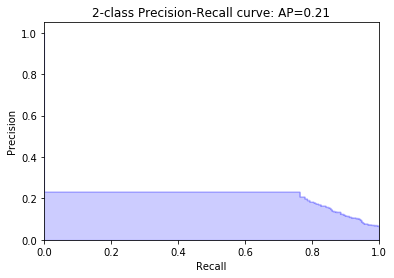

In [20]:
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))